## Edge prediction task

In [ ]:
# Define the GAT model
class GAT_edges(torch.nn.Module):
    def __init__(self, in_channels, out_channels, n_layers=3):
        super(GAT_edges, self).__init__()
        self.gat_list = torch.nn.ModuleList([
            GATv2Conv(in_channels, out_channels, dropout=0.6)] +
            [GATv2Conv(out_channels, out_channels, dropout=0.6)] * (n_layers - 1)
        )

        self.id = torch.nn.Identity()
        self.edge_classifier = torch.nn.ModuleList([
            torch.nn.Linear(out_channels * 2, out_channels * 2)] * 2 +
            [torch.nn.Linear(out_channels * 2, 2),
        ])

    @staticmethod
    def get_edges_embs(nodes_emb, edges_idx):
        node1 = torch.take_along_dim(nodes_emb, edges_idx[:, 0].view(-1, 1), dim=0)
        node2 = torch.take_along_dim(nodes_emb, edges_idx[:, 1].view(-1, 1), dim=0)
        return torch.concat([node1, node2], dim=1)

    def forward(self, x, edge_index, edges_predict):
        for encoder in self.gat_list:
            x = F.dropout(x, p=0.6, training=self.training)
            x = encoder(x, edge_index)
            x = F.elu(x)
        edges_embs = self.get_edges_embs(x, edges_predict)
        x = edges_embs
        for idx, edge_cls in enumerate(self.edge_classifier):
            x_id = self.id(x)
            x = edge_cls(x)
            if idx != len(self.edge_classifier) - 1:
                x = x + x_id
                x = F.relu(x)

        return x

### Construct dataset

In [ ]:
data.x=features
data.to(device)

Data(x=[4039, 41], edge_index=[2, 914795], y=[4039], train_mask=[4039], test_mask=[4039])

In [ ]:
edges = data.edge_index.cpu().numpy().T
while True:
    train_edges, test_edges = train_test_split(edges, train_size=0.8)
    G = nx.Graph()
    G.add_edges_from(train_edges)
    if nx.is_connected(G):
        break
    

In [ ]:
def construct_negative_samples(size_, true_samples):
    samples = set(map(tuple, np.random.randint(0, 4039, size=(size_, 2))))
    samples = samples - true_samples
    return np.array(list(samples))

In [ ]:
true_samples = set(map(tuple, edges))
# Initialize the model_gat_edges, optimizer_gat_edges, and loss function
model_gat_edges = GAT_edges(in_channels=data.x.shape[1], out_channels=128).to(device)
model_gat_edges.load_state_dict(torch.load('model_gat_edges.pth'))
optimizer_gat_edges = torch.optim.Adam(model_gat_edges.parameters(), lr=0.01, weight_decay=5e-4)

# Training loop
def train():
    model_gat_edges.train()
    optimizer_gat_edges.zero_grad()
    negative = construct_negative_samples(len(edges), true_samples)
    x, edge_index = data.x, data.edge_index
    out = model_gat_edges(x, torch.tensor(train_edges).T.to(device), torch.tensor(np.vstack([train_edges, negative])).to(device))
    target = torch.concat(
        [
            torch.ones((len(train_edges),), dtype=torch.long),
            torch.zeros((len(negative),), dtype=torch.long),
        ]
    ).to(device)
    loss = F.cross_entropy(out, target)
    loss.backward()
    optimizer_gat_edges.step()
    return loss.item()

def test():
    model_gat_edges.eval()
    with torch.no_grad():
        negative = construct_negative_samples(len(edges), true_samples)
        x, edge_index = data.x, data.edge_index
        out = model_gat_edges(x, torch.tensor(train_edges).T.to(device), torch.tensor(np.vstack([test_edges, negative])).to(device))
        target = torch.concat(
            [
                torch.ones((len(test_edges),), dtype=torch.long),
                torch.zeros((len(negative),), dtype=torch.long),
            ]
        ).to(device)
        pred = out.max(1)[1]
        f1 = f1_score(target.cpu().numpy(), pred.cpu().numpy())
    return f1

# Train the model_gat_edges
for epoch in range(400):
    loss = train()
    acc = test()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Test F1: {acc:.4f}')

print('Final Test Accuracy:', acc)

Epoch 0, Loss: 0.5622, Test F1: 0.0000
Epoch 10, Loss: 0.5865, Test F1: 0.3116
Epoch 20, Loss: 0.4894, Test F1: 0.3155
Epoch 30, Loss: 0.4789, Test F1: 0.3068
Epoch 40, Loss: 0.4431, Test F1: 0.3113
Epoch 50, Loss: 0.4296, Test F1: 0.3038
Epoch 60, Loss: 0.5218, Test F1: 0.3105
Epoch 70, Loss: 0.4556, Test F1: 0.3103


KeyboardInterrupt: 

In [ ]:
model_gat_edges.eval()
with torch.no_grad():
    negative = construct_negative_samples(len(edges), true_samples)
    x, edge_index = data.x, data.edge_index
    out = model_gat_edges(x, torch.tensor(train_edges).T.to(device), torch.tensor(np.vstack([test_edges, negative])).to(device))
    target = torch.concat(
        [
            torch.ones((len(test_edges),), dtype=torch.long),
            torch.zeros((len(negative),), dtype=torch.long),
        ]
    ).to(device)
    pred = out.max(1)[1]
    f1 = f1_score(target.cpu().numpy(), pred.cpu().numpy())

In [ ]:
print("Roc-auc score of second model out")
roc_auc_score(target.cpu().numpy(), out[:, 1].cpu().numpy())

Roc-auc score of second model out


0.6829534159912126

In [ ]:
print("Model in cross entropy scenario")
print(classification_report(target.cpu().numpy(), pred.cpu().numpy()))

Model in cross entropy scenario
              precision    recall  f1-score   support

           0       1.00      0.00      0.00    839712
           1       0.18      1.00      0.30    182959

    accuracy                           0.18   1022671
   macro avg       0.59      0.50      0.15   1022671
weighted avg       0.85      0.18      0.05   1022671



Если использовать не два выхода сети, и выбирать между ними максимальный, 
А просто использовать второй выход сети, и задать threshold выбора класса в 1.3, 
Получается сильно увеличить метрики.


In [ ]:
print("Model in LogLoss scenario")
print(classification_report(target.cpu().numpy(), (out[:, 1].cpu().numpy() > 1.3)))

Model in LogLoss scenario
              precision    recall  f1-score   support

           0       0.99      0.02      0.03    839712
           1       0.18      1.00      0.31    182959

    accuracy                           0.19   1022671
   macro avg       0.59      0.51      0.17   1022671
weighted avg       0.85      0.19      0.08   1022671



In [ ]:
### Test random model

print("Random model")
print(classification_report(target.cpu().numpy(), np.random.randint(0, 2, target.shape)))

Random model
              precision    recall  f1-score   support

           0       0.82      0.50      0.62    839712
           1       0.18      0.50      0.26    182959

    accuracy                           0.50   1022671
   macro avg       0.50      0.50      0.44   1022671
weighted avg       0.71      0.50      0.56   1022671



In [ ]:
torch.save(model_gat_edges.state_dict(), 'model_gat_edges.pth')

## Imports

In [48]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
from pathlib import Path
import pandas as pd
import numpy as np

import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn.models import GAT
from torch_geometric.nn.conv import GATv2Conv
from torch_geometric.data import Data
import pandas as pd
import networkx as nx

from node2vec import Node2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score

import itertools
from tqdm import tqdm
import re

In [49]:
file_name = 'vk_combined'
group_size = 5_00
user_id = 113074851

def line_to_users(line):
    return split_line(line)[1:]

def split_line(line):
    return re.split(';|,', line.strip())[:]

# Извлекаем все пары пользователей в одном сообществе (ненаправленные)
def combinations(seq):
    yield from itertools.combinations(seq, 2)

In [50]:
# from collections import Counter

# def select_cool(extract_dir):
#     edges = []
#     with open(extract_dir, 'r') as f:
#         for line in tqdm(f):
#             the_line = line_to_users(line)
#             edges+=the_line
#             # if i > 3: break
#     print('Returning')
#     print(Counter(edges).most_common(10))
#     # # подсчитать максимальное кол-во элементов
#     # max_count = edges.count(max(edges, key=lambda i: edges.count(i)))
#     # # найти все элементы 
#     # res = {i for i in edges if edges.count(i) == max_count}
#     # print(res)
    
# select_cool('D:\ROOT\\vk_data\\raw\groups&users all.csv')

# [('93654448', 628), ('88330425', 424), ('126116437', 420), ('4920826', 409), ('2563875', 391), ('28488238', 343), ('25681279', 327), ('117943603', 326), ('14077371', 324), ('113074851', 318)]

In [51]:
# Записываем только сообщества с пользователем
def user_groups(extract_dir, user_id):
    edges = []
    i = 0
    with open(extract_dir, 'r') as f:
        for line in tqdm(f):
            # the_line = split_line(line)
            if str(user_id) in line:
                # print(line)
                edges.append(str(line))
                # i += 1
            # if i > 3: break
    print('Returning')
    # print(edges)
    f = open(str(user_id) + '.txt', "w")
    f.write(''.join([x for x in edges]))
    f.close()
    
user_groups('D:\ROOT\\vk_data\\raw\groups&users all.csv', user_id)

281003it [00:07, 37163.17it/s]

Returning


In [52]:
def vk_combined_generator(extract_dir, name = file_name):
    edges = []
    i = 0
    with open(extract_dir, 'r') as f:
        for line in tqdm(f):
            the_line = line_to_users(line)
            # if len(the_line) < group_size:
            i+=1
            if i%500 == 0: print(i)
            for c in combinations(the_line):
                edge = tuple(map(int, c))
                edges.append(edge)
            # if i > 100: break
    print('Returning')
    f = open(str(name) + '_' + str(group_size) + '.txt', "w")
    f.write('\n'.join('%s %s' % x for x in edges))
    f.close()
    
# vk_edges = vk_combined_generator('D:\ROOT\\vk_data\\raw\groups&users all — копия.csv')
extract_dir = str(user_id)+'.txt'
vk_edges = vk_combined_generator(extract_dir, name=user_id)

1it [00:00,  8.51it/s]

318it [00:22, 13.85it/s]


Returning


In [53]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [54]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [85]:
# Load the Facebook Circles dataset and preprocess
def load_facebook_data():    
    max_nodes = 4_039
    # Load edges
    # edges = pd.read_csv('../data/facebook_combined.txt', delimiter=' ', header=None)
    # edges = pd.read_csv('../data/vk_combined_'+str(group_size)+'.txt', delimiter=' ', header=None)
    edges = pd.read_csv(str(user_id)+'_'+str(group_size)+'.txt', delimiter=' ', header=None)
    my_dict = {}
    i = 0
    for j in set(list(edges[0])+list(edges[1])):
        if i >= max_nodes: break
        if j not in my_dict:
            my_dict[j] = i
            i += 1
    

    edges = edges.loc[edges[0].isin(my_dict)]
    edges = edges.loc[edges[1].isin(my_dict)]

    print('Indexing')  

    edges[0] = edges[0].replace(my_dict)
    edges[1] = edges[1].replace(my_dict)
      
    print('Indexed')
    # edges = pd.read_csv('D:\ROOT\\vk_data\\raw\\groups&users.csv', delimiter=' ', header=None)
    edges = edges.values.T

    # Load labels (assuming binary classification for gender)
    gender_labels = []
    features = []
    for feat in Path("../data/facebook/").glob("*.featnames"):
        df = pd.read_csv(feat, sep=" ", index_col=0, header=None)
        gender_idx = df.index[df.iloc[:, 0].str.find("gender") != -1].values
        feature_names = (df[1] + df[2] + df[3].astype(str)).values

        # get label features
        df = pd.read_csv(feat.with_suffix(".feat"), sep=" ", index_col=0, header=None)
        tmp_df = pd.read_csv(feat.with_suffix(".egofeat"), sep=" ", header=None)
        tmp_df.columns = tmp_df.columns + 1
        tmp_df.index = [int(feat.stem)]
        df = pd.concat([tmp_df, df], axis=0)

        labels = df.iloc[:, gender_idx]
        gender_labels.append(labels.iloc[:, 0])
        print(f"для {feat}")
        stat_gender_collision = (labels.iloc[:, 0] != labels.iloc[:, 1]).sum() / labels.shape[0]
        print(f"количество правильных гендеров: {stat_gender_collision}")
        print()
        # иногда почему то гендер пересекается...

        df.columns = feature_names
        features.append(df)

    gender_labels = pd.concat(gender_labels, axis=0)
    gender_labels = gender_labels[~gender_labels.index.duplicated(keep="first")]
    features = pd.concat(features, axis=0)
    features = features[~features.index.duplicated(keep="first")]
    # Тут в фичах будет довольно много плохих фичей, поэтому их стоит дропнуть
    good_features = features.isna().sum() 
    good_features = good_features[(good_features / features.shape[0]) < 0.2].index
    features = features[good_features].fillna(0)

    gender_labels = torch.tensor(gender_labels.sort_index().values)
    features = torch.tensor(features.sort_index().values, dtype=torch.float32)
    edge_index = torch.tensor(edges, dtype=torch.long)

    return features, edge_index, gender_labels[0:len(edges[0])]

# load_facebook_data()[1]
features, edge_index, labels = load_facebook_data()


4039
0          3055081
1          3055081
2          3055081
3          3055081
4          3055081
            ...   
3394103    5312460
3394104    5312460
3394105    5312460
3394106    5312460
3394107    5312460
Name: 0, Length: 3394108, dtype: int64
Indexing
Indexed
для ..\data\facebook\0.featnames
количество правильных гендеров: 0.9827586206896551

для ..\data\facebook\107.featnames
количество правильных гендеров: 0.988527724665392

для ..\data\facebook\1684.featnames
количество правильных гендеров: 0.9798234552332913

для ..\data\facebook\1912.featnames
количество правильных гендеров: 0.9880952380952381

для ..\data\facebook\3437.featnames
количество правильных гендеров: 0.9598540145985401

для ..\data\facebook\348.featnames
количество правильных гендеров: 0.9868421052631579

для ..\data\facebook\3980.featnames
количество правильных гендеров: 0.9666666666666667

для ..\data\facebook\414.featnames
количество правильных гендеров: 0.9625

для ..\data\facebook\686.featnames
количество

### Define model

In [86]:
# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [87]:
# Prepare the data
features, edge_index, labels = load_facebook_data()
# features can be random
random_features = torch.randn(labels.shape[0], 32)  # 16-dim node features

data = Data(x=random_features, edge_index=edge_index, y=labels)

# Split the data into train and test sets
train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
train_mask[:int(0.8 * data.num_nodes)] = True
test_mask = ~train_mask

data.train_mask = train_mask
data.test_mask = test_mask


4039
0          3055081
1          3055081
2          3055081
3          3055081
4          3055081
            ...   
3394103    5312460
3394104    5312460
3394105    5312460
3394106    5312460
3394107    5312460
Name: 0, Length: 3394108, dtype: int64
Indexing
Indexed
для ..\data\facebook\0.featnames
количество правильных гендеров: 0.9827586206896551

для ..\data\facebook\107.featnames
количество правильных гендеров: 0.988527724665392

для ..\data\facebook\1684.featnames
количество правильных гендеров: 0.9798234552332913

для ..\data\facebook\1912.featnames
количество правильных гендеров: 0.9880952380952381

для ..\data\facebook\3437.featnames
количество правильных гендеров: 0.9598540145985401

для ..\data\facebook\348.featnames
количество правильных гендеров: 0.9868421052631579

для ..\data\facebook\3980.featnames
количество правильных гендеров: 0.9666666666666667

для ..\data\facebook\414.featnames
количество правильных гендеров: 0.9625

для ..\data\facebook\686.featnames
количество

In [88]:
train_mask

tensor([ True,  True,  True,  ..., False, False, False])

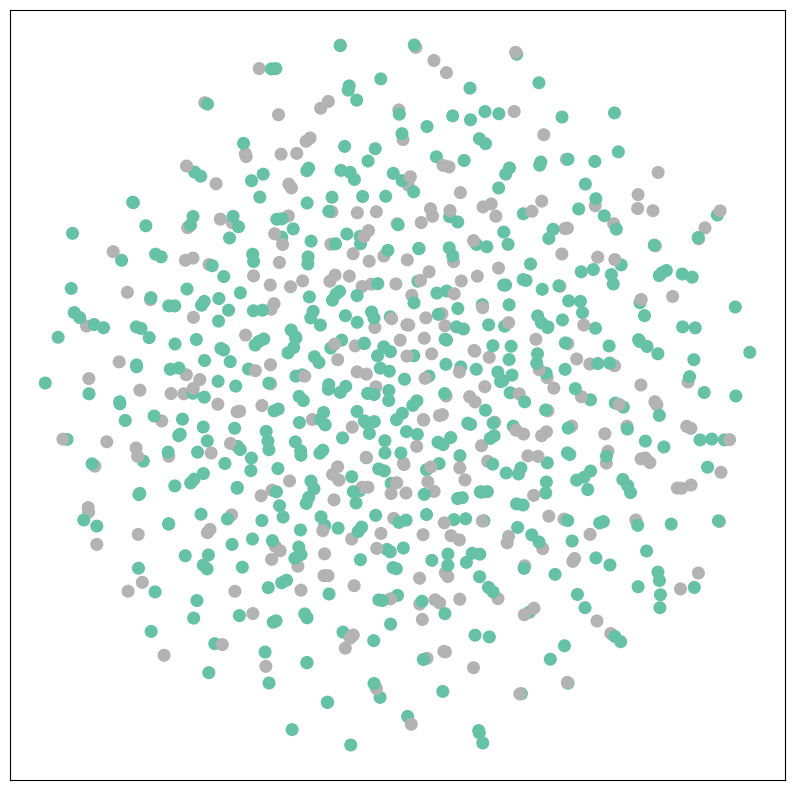

In [89]:
color = labels[data.test_mask]
visualize(data.x[data.test_mask], color)

## Craft features from node2vec

In [90]:
import pickle
if not Path("../data/n2v_embs.pcl").exists():
    # Prepare the graph
    G = nx.from_edgelist(data.edge_index.cpu().numpy().T)

    # Apply Node2Vec
    node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
    model_nv = node2vec.fit(window=10, min_count=1, batch_words=4)

    # Extract node embeddings
    node_embeddings = {node: model_nv.wv[node] for node in G.nodes()}

    n2v_embs = [node_embeddings[idx] for idx in range(4039)]
    with open("../data/n2v_embs.pcl", "wb") as f:
        pickle.dump(np.vstack(n2v_embs), f)
    n2v_embs = np.vstack(n2v_embs)
else:
    with open("../data/n2v_embs.pcl", "rb") as f:
        n2v_embs = pickle.load(f)

### GCN model

In [91]:
data.x=torch.tensor(np.vstack(n2v_embs), dtype=torch.float32)
data.to(device)

# Initialize the model, optimizer_gcn_nv, and loss function
model_gcn_nv = GCN(in_channels=data.x.shape[1], hidden_channels=64, out_channels=2).to(device)
optimizer_gcn_nv = torch.optim.Adam(model_gcn_nv.parameters(), lr=0.01, weight_decay=5e-4)

# Training loop
def train():
    model_gcn_nv.train()
    optimizer_gcn_nv.zero_grad()
    out = model_gcn_nv(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer_gcn_nv.step()
    return loss.item()

def test():
    model_gcn_nv.eval()
    with torch.no_grad():
        logits = model_gcn_nv(data)
        test_mask = data.test_mask
        pred = logits[test_mask].max(1)[1]
        acc = pred.eq(data.y[test_mask]).sum().item() / test_mask.sum().item()
    return acc

# Train the model_gcn_nv
for epoch in range(100):
    loss = train()
    acc = test()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}')

print('Final Test Accuracy:', acc)

Epoch 0, Loss: 0.7291, Test Accuracy: 0.6312
Epoch 10, Loss: 0.6967, Test Accuracy: 0.6312
Epoch 20, Loss: 0.6770, Test Accuracy: 0.6225
Epoch 30, Loss: 0.6657, Test Accuracy: 0.6312
Epoch 40, Loss: 0.6657, Test Accuracy: 0.6312
Epoch 50, Loss: 0.6655, Test Accuracy: 0.6287
Epoch 60, Loss: 0.6646, Test Accuracy: 0.6300
Epoch 70, Loss: 0.6622, Test Accuracy: 0.6275
Epoch 80, Loss: 0.6608, Test Accuracy: 0.6262
Epoch 90, Loss: 0.6608, Test Accuracy: 0.6213
